# ATP Tennis Data - Player Matchup Percentage




Data that we will be adding for matchups:


* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

We will see if this data helps improve our models

### Best result so far

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

# Summary of Results

```
Model Score: 0.6845374746792707

ROC/AUC Score: 0.6845201548419834
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-matchup_percentage"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all  columns that doesn't have percentage
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('percentage', col)]
    data = data.drop(matchup_columns, axis=1)

    # drop all  diff columns
    matchup_diff_columns = [col for col in data.columns if re.search(r'matchup.+diff', col)]
    data = data.drop(matchup_diff_columns, axis=1)

    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)


    
    print(f'After: data.shape {data.shape}')
    return data




Before: data.shape (44429, 5299)
After: data.shape (44429, 5263)
Before: data.shape (14810, 5299)
After: data.shape (14810, 5263)


In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = filter_features)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games_won_percentage',
 'p1_matchup_sets_won_percentage',
 'p1_matchup_win_percentage',
 'p2_matchup_games_won_percentage',
 'p2_matchup_sets_won_percentage',
 'p2_matchup_win_percentage']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6615124915597569

ROC/AUC Score: 0.6615126562620564
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4883  2498
Win   2515  4914


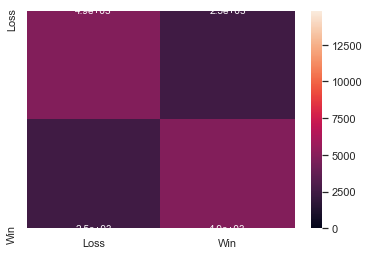

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_knn = knn.predict()

Model Score: 0.6105334233625929

ROC/AUC Score: 0.6105420251788284
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4526  2855
Win   2913  4516


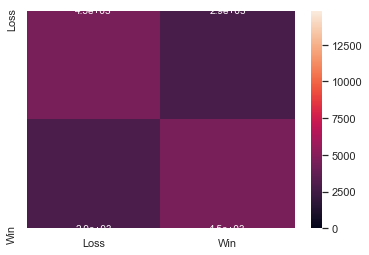

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_dt = dt.predict()

Model Score: 0.6027008777852803

ROC/AUC Score: 0.6026932028295356
              precision    recall  f1-score   support

        Loss       0.60      0.60      0.60      7381
         Win       0.60      0.61      0.60      7429

    accuracy                           0.60     14810
   macro avg       0.60      0.60      0.60     14810
weighted avg       0.60      0.60      0.60     14810

      Loss   Win
Loss  4431  2950
Win   2934  4495


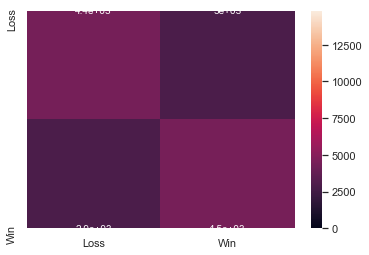

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6338284942606347

ROC/AUC Score: 0.6340747870884431
              precision    recall  f1-score   support

        Loss       0.61      0.71      0.66      7381
         Win       0.66      0.56      0.60      7429

    accuracy                           0.63     14810
   macro avg       0.64      0.63      0.63     14810
weighted avg       0.64      0.63      0.63     14810

      Loss   Win
Loss  5241  2140
Win   3283  4146


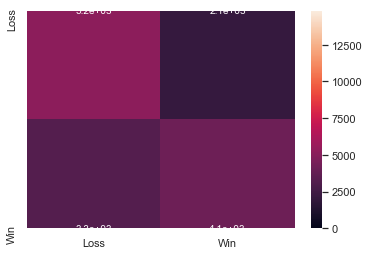

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3670            9.24m
         2           1.3505            8.91m
         3           1.3357            8.78m
         4           1.3238            8.70m
         5           1.3130            8.58m
         6           1.3043            8.50m
         7           1.2957            8.40m
         8           1.2887            8.32m
         9           1.2822            8.22m
        10           1.2766            8.11m
        20           1.2381            7.36m
        30           1.2075            6.47m
        40           1.1888            5.48m
        50           1.1757            4.56m
        60           1.1680            3.64m
        70           1.1646            2.72m
        80           1.1582            1.80m
        90           1.1541           53.79s
       100           1.1519            0.00s


Model Score: 0.6845374746792707

ROC/AUC Score: 0.6845201548419834
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810

      Loss   Win
Loss  5013  2368
Win   2304  5125


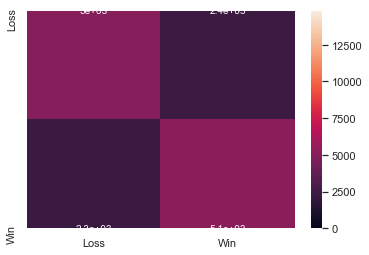

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_ab = ab.predict()

Model Score: 0.6655638082376772

ROC/AUC Score: 0.6655254988611058
              precision    recall  f1-score   support

        Loss       0.67      0.65      0.66      7381
         Win       0.66      0.68      0.67      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4825  2556
Win   2397  5032


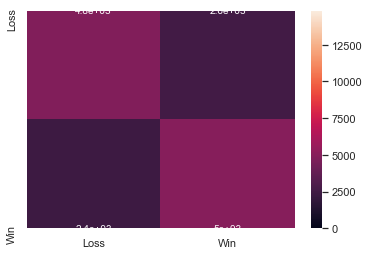

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
84,LogisticRegression,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.661512,0.661513,"{""0"": {""0"": 4883, ""1"": 2515}, ""1"": {""0"": 2498,...","{""Loss"": {""precision"": 0.6600432549337659, ""re...",../models/logisticregression-1998-2018-ohe-mat...,0.0,0.0,0.0
85,KNeighborsClassifier,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.610533,0.610542,"{""0"": {""0"": 4526, ""1"": 2913}, ""1"": {""0"": 2855,...","{""Loss"": {""precision"": 0.6084151095577363, ""re...",../models/kneighborsclassifier-1998-2018-ohe-m...,0.0,0.0,0.0
86,DecisionTreeClassifier,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.602701,0.602693,"{""0"": {""0"": 4431, ""1"": 2934}, ""1"": {""0"": 2950,...","{""Loss"": {""precision"": 0.6016293279022403, ""re...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0
87,RandomForestClassifier,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.633828,0.634075,"{""0"": {""0"": 5241, ""1"": 3283}, ""1"": {""0"": 2140,...","{""Loss"": {""precision"": 0.6148521820741436, ""re...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0
88,GradientBoostingClassifier,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.684537,0.684520,"{""0"": {""0"": 5013, ""1"": 2304}, ""1"": {""0"": 2368,...","{""Loss"": {""precision"": 0.6851168511685117, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,9.0,9.0
89,AdaBoostClassifier,ohe-matchup_percentage,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.665564,0.665525,"{""0"": {""0"": 4825, ""1"": 2397}, ""1"": {""0"": 2556,...","{""Loss"": {""precision"": 0.6680974799224592, ""re...",../models/adaboostclassifier-1998-2018-ohe-mat...,0.0,1.0,1.0


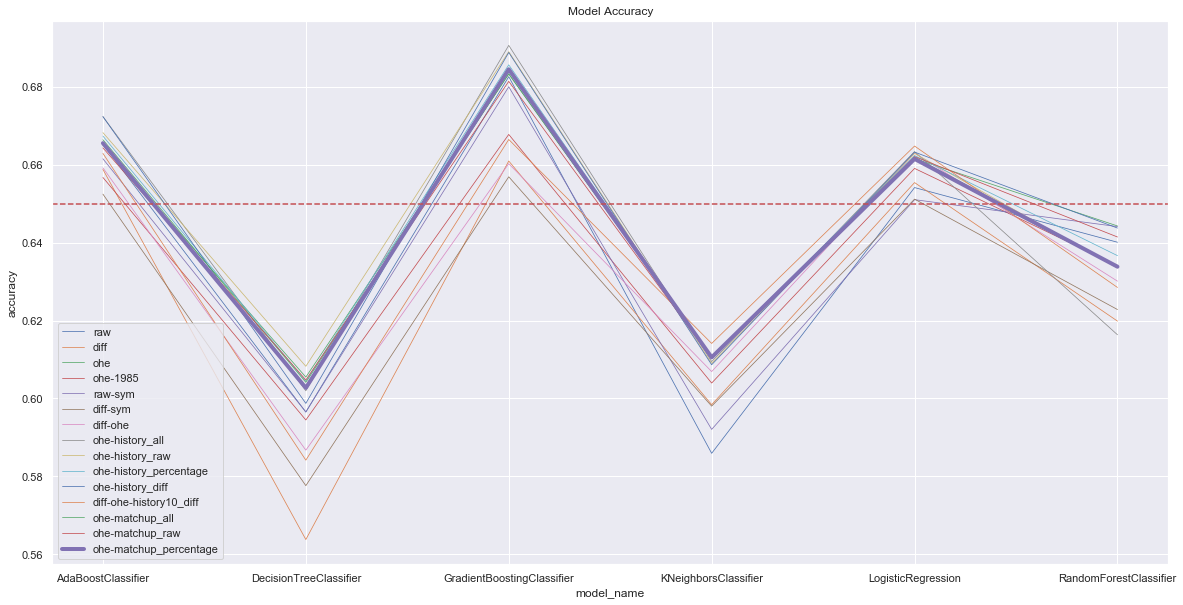

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


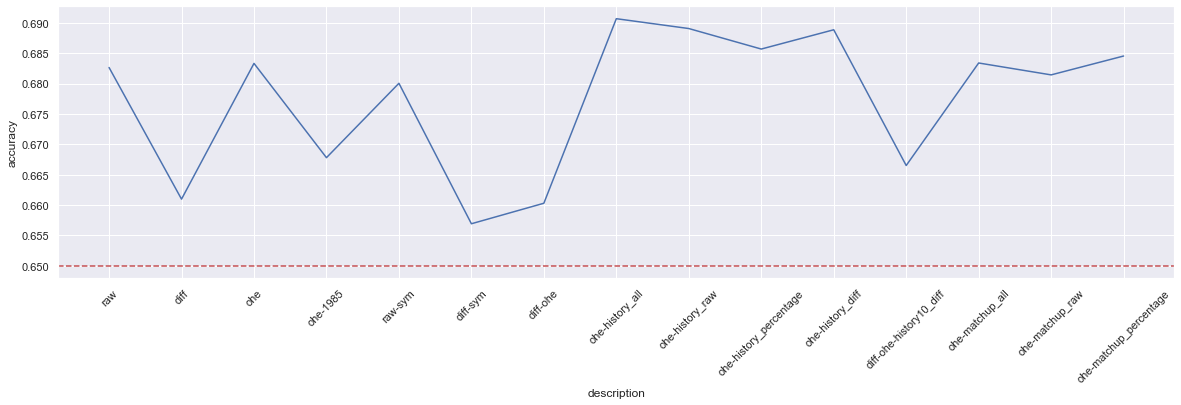

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

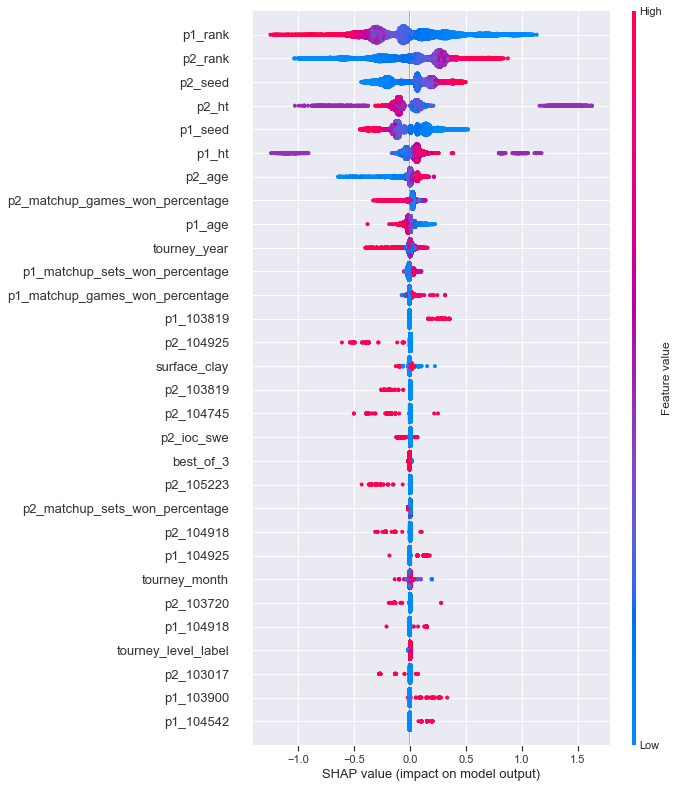

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

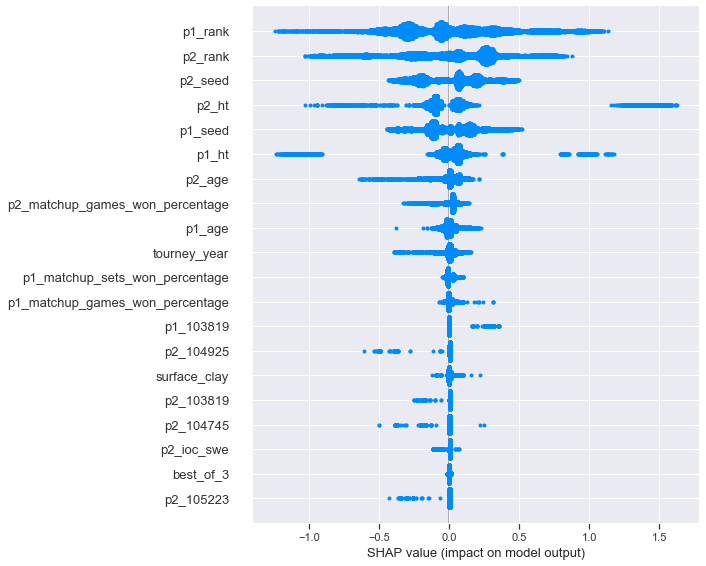

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-21 04:19
